- restart modelling
- completely change the programs of feature engineering to prevent leakage

In [1]:
import sys
import copy
import random
import feather
import warnings
import numpy as np
import pandas as pd
from time import time
import lightgbm as lgb
from collections import Counter
from sklearn import preprocessing
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score

import riiideducation

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows",2000)
np.set_printoptions(precision=8)
warnings.filterwarnings("ignore")

In [2]:
DIR = "../input/riiid-test-answer-prediction/"
train = pd.read_feather("../input/riid-train/train.feather")
lectures = pd.read_csv(DIR+"lectures.csv")
questions = pd.read_csv(DIR+"questions.csv")
example_test = pd.read_csv(DIR+"example_test.csv")

# preprocess

In [3]:
train.drop(["row_id", 'user_answer'], axis=1, inplace=True)
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].fillna(value = False).astype(bool)

user_answers_df = train.groupby('user_id').agg({'answered_correctly': ['mean']}).copy()
user_answers_df.columns = ["correct_rate_before_ans"]

#content_answers_df = train.groupby('content_id').agg({'answered_correctly': ['mean']}).copy()
#content_answers_df.columns = ['mean_accuracy_by_content']

#user_content_answers_df = train.groupby(['user_id', 'content_id']).agg({'answered_correctly': ['mean', 'count']}).copy()
#user_content_answers_df.columns = ['mean_user_content_accuracy', 'content_questions_answered']

In [4]:
le = preprocessing.LabelEncoder()
train["prior_question_had_explanation"] = le.fit_transform(train["prior_question_had_explanation"])

In [5]:
# to get first index of a particular user
#for i in train.groupby("user_id").first().index:
#    if i > 90000000:
#        print(i)
#        break

In [6]:
train = train.iloc[90007298:,:]
train = train.sort_values(['user_id', 'timestamp'])
train['task_container_id'] = (train.groupby('user_id')['task_container_id'].transform(lambda x: pd.factorize(x)[0]).astype('int16'))
train.head(10)

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
90007298,0,1911932135,4705,0,0,0,4294967295,0
90007299,10764,1911932135,4877,0,1,1,39000,0
90007300,45162,1911932135,3923,0,2,1,5000,0
90007301,77874,1911932135,3893,0,3,0,31000,0
90007302,147369,1911932135,6318,0,4,1,30000,0
90007303,178960,1911932135,4623,0,5,0,67000,0
90007304,235152,1911932135,5318,0,6,1,29000,0
90007305,270177,1911932135,8497,0,7,1,54000,0
90007306,308144,1911932135,6683,0,8,0,33000,0
90007307,327228,1911932135,4023,0,9,0,35000,0


In [7]:
train.shape, len(train.user_id.unique())

((11223034, 8), 43496)

# Feature engineering

In [8]:
def get_data(df, test_set=False):
    if test_set == False:
        df = df.loc[df['answered_correctly'] != -1].reset_index(drop=True)
        
        correct_rate = np.array([])
        for i, (ins_id, user_sample) in tqdm(enumerate(df.groupby('user_id', sort=False)), total=train.user_id.nunique(), desc='user_id', position=0):
            cum_correct_num = user_sample["answered_correctly"].cumsum().values
            cum_answer_num = [i+1 for i in range(user_sample.shape[0])]
            
            correct_rate_list = [cum_correct_num[i]/cum_answer_num[i] for i in range(len(cum_answer_num))]
            correct_rate_list = [-1] + correct_rate_list[:-1]
            correct_rate = np.concatenate([correct_rate, correct_rate_list])
            
        df["correct_rate_before_ans"] = correct_rate  
    else:
        df = df.merge(user_answers_df, how = 'left', on = 'user_id') # for correct_rate_before_ans
        #df = df.merge(content_answers_df, how = 'left', on = 'content_id')

    # https://stackoverflow.com/questions/25888207/pandas-join-dataframes-on-field-with-different-names
    df = df.merge(questions[["question_id", "part"]], how="left", left_on=['content_id'], right_on=['question_id'])
    df.drop(["timestamp", "question_id"], axis=1, inplace=True)
    df.fillna(value = -1, inplace = True)
    return df
train = get_data(train)

In [9]:
target = 'answered_correctly'
columns = ["correct_rate_before_ans", 'content_id', 'task_container_id', 'prior_question_had_explanation',
           'prior_question_elapsed_time', 'part'] #'mean_accuracy_by_content'

drop_columns = [i for i in train.columns if i not in columns + [target] + ["user_id"]] 
train.drop(drop_columns, axis=1, inplace=True)

In [10]:
train.head()

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,correct_rate_before_ans,part
0,1911932135,4705,0,0,4294967295,0,-1.000000,5
1,1911932135,4877,1,1,39000,0,0.000000,5
2,1911932135,3923,2,1,5000,0,0.500000,5
3,1911932135,3893,3,0,31000,0,0.666667,5
4,1911932135,6318,4,1,30000,0,0.500000,5


# modelling

In [11]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [12]:
categoricals = ["content_id", "part"]
def modelling_lgb(X_train, y_train):
    params = {'objective': 'binary', "metric": 'auc','eval_metric':'auc', 'boosting_type': 'gbdt', 'tree_learner': 'serial', 'learning_rate': 0.01, 
               "num_leaves": 50, 'random_seed':44, 'max_depth': 10} 
    
    groups = np.array(X_train.user_id.values)
    n_folds=5
    
    models = []
    valid = np.zeros([X_train.shape[0]])
        
    features_list = [i for i in X_train.columns if i != "user_id"]
    feature_importance_df = pd.DataFrame(features_list, columns=["Feature"])
    
    for i , (train_index, test_index) in enumerate(stratified_group_k_fold(X_train, y_train, groups, k=n_folds, seed=0)):
        print("Fold {}".format(i+1))
        X_train2 = X_train.iloc[train_index,:]
        y_train2 = y_train.iloc[train_index]
        X_train2.drop("user_id", axis=1, inplace=True)

        X_valid2 = X_train.iloc[test_index,:]
        
        # https://stackoverflow.com/questions/15705630/get-the-rows-which-have-the-max-count-in-groups-using-groupby
        #max_idx = X_valid2.groupby(['user_id'])['task_container_id'].transform(max) == train['task_container_id']
        #min_idx = X_valid2.groupby(['user_id'])['task_container_id'].transform(min) == train['task_container_id']
        #X_valid2 = X_valid2[max_idx|min_idx]
        
        y_valid2 = y_train.iloc[test_index]
        X_valid2.drop("user_id", axis=1, inplace=True)

        lgb_train = lgb.Dataset(X_train2, y_train2)
        lgb_eval = lgb.Dataset(X_valid2, y_valid2, reference=lgb_train)
        
        clf = lgb.train(params, lgb_train,valid_sets=[lgb_train, lgb_eval], 
               num_boost_round=300,early_stopping_rounds=10,verbose_eval = 100, categorical_feature=categoricals) 
        feature_importance_df["Fold_"+str(i+1)] = clf.feature_importance()

        valid_predict = clf.predict(X_valid2, num_iteration = clf.best_iteration)
        valid[test_index] = valid_predict
        
        models.append(clf) 
        
    feature_importance_df["Average"] = np.mean(feature_importance_df.iloc[:,1:n_folds+1], axis=1)
    feature_importance_df["Std"] = np.std(feature_importance_df.iloc[:,1:n_folds+1], axis=1)
    feature_importance_df["Cv"] = feature_importance_df["Std"] / feature_importance_df["Average"]
    feature_importance_df = feature_importance_df.sort_values("Average", ascending=False).reset_index(drop=True)
            
    score = roc_auc_score(y_train, valid)
    print("Overall ROC AUC: ", score)
        
    return models, feature_importance_df
models, feature_importance_df = modelling_lgb(train[columns + ["user_id"]], train[target])

Fold 1
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.694448	valid_1's auc: 0.697822
[200]	training's auc: 0.703934	valid_1's auc: 0.706315
[300]	training's auc: 0.709389	valid_1's auc: 0.711066
Did not meet early stopping. Best iteration is:
[300]	training's auc: 0.709389	valid_1's auc: 0.711066
Fold 2
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.69491	valid_1's auc: 0.693569
[200]	training's auc: 0.704439	valid_1's auc: 0.702769
[300]	training's auc: 0.70978	valid_1's auc: 0.707549
Did not meet early stopping. Best iteration is:
[300]	training's auc: 0.70978	valid_1's auc: 0.707549
Fold 3
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.696189	valid_1's auc: 0.690305
[200]	training's auc: 0.705281	valid_1's auc: 0.698824
[300]	training's auc: 0.710517	valid_1's auc: 0.703595
Did not meet early stopping. Best iteration is:
[300]	training's auc: 0.710517	valid_1's auc: 0.70

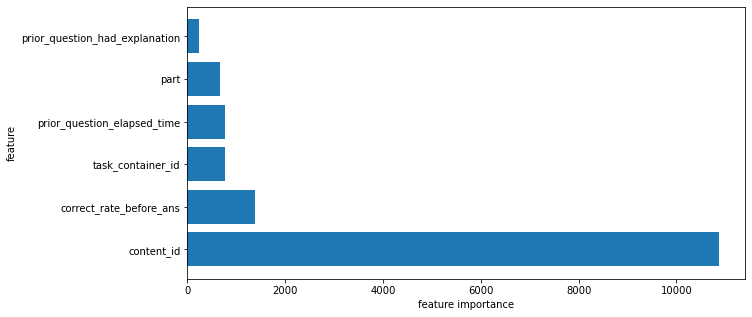

In [13]:
import matplotlib.pyplot as plt 
x = list(feature_importance_df["Feature"].values)
y = feature_importance_df["Average"].values

x_position = np.arange(len(x))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)
ax.barh(x_position, y, tick_label=x)
ax.set_ylabel('feature')
ax.set_xlabel('feature importance')
plt.show()

# prediction

In [14]:
del train

In [15]:
env = riiideducation.make_env()
iter_test = env.iter_test()

for (test_df, sample_prediction_df) in iter_test:
    y_preds = []

    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].fillna(value = False).astype(bool)
    test_df = get_data(test_df, test_set=True)
    test_df["prior_question_had_explanation"] = le.fit_transform(test_df["prior_question_had_explanation"])

    for model in models:
        y_pred = model.predict(test_df[columns], num_iteration=model.best_iteration)
        y_preds.append(y_pred)

    y_preds = sum(y_preds) / len(y_preds)
    test_df['answered_correctly'] = y_preds
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])